# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import PIL
import matplotlib.pyplot as plt

/Users/atulramkrishnan/miniforge3/envs/pytorch_ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config / Globals

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
batch_size = 32

CNN_only_models = [
    "VGG16_SegNet",
    "VGG16_SegNet_pretrained",
    "VGG11_SegNet_pretrained"]
ConvLSTM_models = ["VGG11_SegNet_ConvLSTM_pretrained"]

In [38]:
train_path = "./data/train_index_medium.txt"
val_path = "./data/val_index_small.txt"
basic_demo_path = "./data/test_index_demo.txt"
test_challenging_path = './data/test_challenging_demo.txt'
test_path = './data/test_index_merged.txt'
pretrained_models_path = './pretrained/'
saved_images_path = './saved_images/'

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataloader

In [6]:
class LaneData(Dataset):
    """
    This class implements a custom Dataloder for our files.
    Parameters
    ----------
        index_path: str
            Directory containing the file paths of the images.
        return_sequence: bool, optional
            Whether or not to return a sequence of data (for sequence models).
        transform: torchvision.transforms.transforms.Compose, optional
            Optional transform to be applied on a sample input.
        target_transform: torchvision.transforms.transforms.Compose, optional
            Optional transform to be applied on the sample target.
        max_samples: int
            Specify the number of images you want to load.

    Example
    -------
    train_loader = torch.utils.data.DataLoader(
                    LaneData(
                        index_path=train_path,
                        return_sequence=False,
                        transform=transformation,
                        target_transform=transformation,
                        max_samples=None),
                        batch_size=batch_size,
                        shuffle=True
                       )

    for idx, (input, target) in enumerate(train_loader):
        print(input.shape, target.shape)

    """

    def __init__(self,
                 index_path,
                 return_sequence=False,
                 transform=None,
                 target_transform=None,
                 max_samples=None):
        """
        Initialize the dataloader.
        """
        self.index_path = index_path
        self.return_sequence = return_sequence
        self.transform = transform
        self.target_transform = target_transform
        self.max_samples = max_samples
        self.__parseIndexFile()

    def __parseIndexFile(self):
        """
        Helper function that reads the index file
        and adds the image locations to a list.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        self.data_list = []
        with open(self.index_path, 'r', encoding='utf-8-sig') as index_file:
            for i, line in enumerate(index_file):
                if self.max_samples is not None and i >= self.max_samples:
                    break
                data = line.split()
                self.data_list.append(data)

    def __len__(self):
        """
        Returns the length of the dataset.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        Gets the item at location idx

        Parameters
        ----------
        idx: int
            The index of the data sample to be returned.
        Returns
        -------
        sample: (torch.Tensor, torch.Tensor)
            A tuple containing the image and its label.
        """
        data = self.data_list[idx]
        sample = ()

        if not self.return_sequence:
            image = PIL.Image.open(data[4])
            label = PIL.Image.open(data[5])
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            label = torch.squeeze(label)
            sample = (image, label)
        else:
            image_list = []
            for i in range(5):
                image = PIL.Image.open(data[i])
                if self.transform:
                    image = self.transform(image)
                image_list.append(torch.unsqueeze(image, dim=0))
            image_list = torch.cat(image_list, 0)
            label = PIL.Image.open(data[5])
            if self.target_transform:
                label = self.target_transform(label)
            label = torch.squeeze(label)
            sample = (image_list, label)

        return sample

# Early Stopping

In [7]:
class EarlyStopping:
    """
    Implements early stopping mechanism.
    Saves the model as long as the validation score is decreasing.
    Stops the training if the validation score does not improve after
    a given patience.

    Parameters
    ----------
    patience: int
            Given number of attempts after validation loss
            has stopped improving before stopping training.
    save_path: str
            Path where the model should be saved.
    min_delta: float, optional
            The least amount by which the new validation loss
            should be less than the previous best validation loss
            to be counted as an improvement.

    Example
    -------
    model = model_dispatcher.models[config.model_to_train]

    criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor(
            config.class_weight)).to(
        config.device)

    optimizer = torch.optim.Adam(model.parameters(), config.learning_rate)

    early_stopping = EarlyStopping(
        patience=2,
        save_path=config.pretrained_path +
        model.__class__.__name__,
        min_delta=0.001)

    train_losses = []
    val_losses = []
    for epoch in range(1, config.num_epochs + 1):
        train_losses.append(
            train(
                model,
                epoch,
                train_loader,
                optimizer,
                criterion,
                10,
                config.device))
        val_loss = val(model, epoch, val_loader, criterion, config.device)
        val_losses.append(val_loss)
        if early_stopping(model, val_loss):
            break

    """

    def __init__(self, patience, save_path, min_delta=0.01):
        """
        Initializes the class
        """
        self.patience = patience
        self.save_path = save_path
        self.min_delta = min_delta
        self.best_val_loss = np.inf
        self.counter = 0

    def __call__(self, model, val_loss):
        """
        Compares the validation loss to the previous best validation loss
        and if we match the criteria for stopping the training.

        Parameters
        ----------
        model: torch.nn.Module
                PyTorch model that we want to save.
        val_loss: float
                Validation loss to be compared
                against previous best validation loss.

        Returns
        -------
        bool
            Whether we match the criteria for early stopping or not.
        """
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0
            self.__save_checkpoint(model)
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True

    def __save_checkpoint(self, model):
        """
        Saves the model to the specified path.

        Parameters
        ----------
        model: torch.nn.Module
                PyTorch model to be saved.

        Returns
        -------
        None
        """
        torch.save(model.state_dict(), self.save_path)

# Models

In [8]:
class ConvLSTMCell(nn.Module):
    """
    ConvLSTM implementation by Andrea Palazzi and Davide Abati
    https://github.com/ndrplz/ConvLSTM_pytorch

    ConvLSTM is a type of recurrent neural network
    for spatio-temporal prediction that has convolutional structures
    in both the input-to-state and state-to-state transitions.

    This class implements a single cell of the ConvLSTM model.

    Parameters
    ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.

    Example
    -------
    convlstmcell = ConvLSTMCell(input_size=(height,width),
                                          input_dim,
                                          hidden_dim,
                                          kernel_size,
                                          bias)

    """

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        """
        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        """
        Returns the output of the ConvLSTM cell.
        """
        h_cur, c_cur = cur_state

        # concatenate along channel axis
        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(
            combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        """
        Initializes the hidden state and cell state for the ConvLSTM cell.
        """
        return (
            torch.zeros(
                batch_size,
                self.hidden_dim,
                self.height,
                self.width).to(device),
            torch.zeros(
                batch_size,
                self.hidden_dim,
                self.height,
                self.width).to(device))


class ConvLSTM(nn.Module):
    """
    ConvLSTM implementation by Andrea Palazzi and Davide Abati
    https://github.com/ndrplz/ConvLSTM_pytorch

    ConvLSTM is a type of recurrent neural network
    for spatio-temporal prediction that has convolutional structures
    in both the input-to-state and state-to-state transitions.

    This class implements the ConvLSTM model.

    Parameters
    ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        num_layers: int
            Number of layers in the model.
        batch_first: bool, optional
            Whether or not the batches are processed with the batch dim first.
        bias: bool, optional
            Whether or not to add the bias.
        return_all_layers: bool, optional
            Whether or not to return all the outputs and hidden layers

    Example
    -------
    # (t, b, c, h, w) or (b, t, c, h, w)
    inp_tensor = torch.rand([10, 5, 3, 28, 28])

    convlstm = ConvLSTM(
                              input_size=(4,8),
                              input_dim=512,
                              hidden_dim=[512, 512],
                              kernel_size=(3,3),
                              num_layers=2,
                              batch_first=False,
                              bias=True,
                              return_all_layers=False
                            )
    output = convlstm(inp_tensor)
    """

    def __init__(
            self,
            input_size,
            input_dim,
            hidden_dim,
            kernel_size,
            num_layers,
            batch_first=False,
            bias=True,
            return_all_layers=False):
        """
        Initialize ConvLSTM model.
        """
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having
        # len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            if i == 0:
                cur_input_dim = self.input_dim
            else:
                cur_input_dim = self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape
            (time_steps, batch_size, inp_channels, height, width)
            or (batch_size, time_steps, inp_channels, height, width)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :],
                    cur_state=[h, c])

                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output = layer_output.permute(1, 0, 2, 3, 4)

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        """
        Initializes the hidden layers for all cells in the model.
        """
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        """
        Checks whether the kernel_size is in the correct format.
        """
        if not (isinstance(kernel_size, tuple)
           or (isinstance(kernel_size, list)
           and all(
                [isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        """
        Make sure that both `kernel_size` and `hidden_dim`
        are lists having len == num_layers
        """
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [9]:
class VGG16_SegNet(nn.Module):
    """
    References used when implementing SegNet:
    https://github.com/vinceecws/SegNet_PyTorch/blob/master/SegNet.py
    https://github.com/qinnzou/Robust-Lane-Detection/blob/master/LaneDetectionCode/model.py
    https://github.com/say4n/pytorch-segnet/blob/master/src/model.py

    This class implements the SegNet model with the encoder as the same
    topology as VGG16. This implementation does not use pretrained weights
    for the encoder.

    Example
    -------
    model = VGG16_SegNet()
    # (batch_size, inp_channels, width, height)
    input = torch.rand([100, 3, 128, 256])
    output = model(input)
    """

    def __init__(self):
        """
        Initializes the VGG11_SegNet model.
        """
        super(VGG16_SegNet, self).__init__()
        self.maxpool = nn.MaxPool2d(
            kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.encoder5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.decoder4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=(3, 3), padding="same"),
        )

    def forward(self, x):
        """
        Returns the output of the model.
        Parameters
        ----------
        input : torch.Tensor((batch_size, inp_channels, width, height))
            Input image.

        Returns
        -------
        output: torch.Tensor((batch_size, 2, width, height))
            Segmented binary image.

        """
        x, idx1 = self.maxpool(self.encoder1(x))
        x, idx2 = self.maxpool(self.encoder2(x))
        x, idx3 = self.maxpool(self.encoder3(x))
        x, idx4 = self.maxpool(self.encoder4(x))
        x, idx5 = self.maxpool(self.encoder5(x))

        x = self.unpool(x, idx5)
        x = self.unpool(self.decoder5(x), idx4)
        x = self.unpool(self.decoder4(x), idx3)
        x = self.unpool(self.decoder3(x), idx2)
        x = self.unpool(self.decoder2(x), idx1)
        x = self.decoder1(x)

        return F.log_softmax(x, dim=1)

In [10]:
class VGG16_SegNet_pretrained(nn.Module):
    """
    This class implements the SegNet model with the encoder as the
    same topology as VGG16. This implementation uses pretrained weights
    for the encoder.

    Example
    -------
    model = VGG16_SegNet()
    # (batch_size, inp_channels, width, height)
    input = torch.rand([100, 3, 128, 256])
    output = model(input)
    """

    def __init__(self):
        """
        Initializes the VGG11_SegNet model.
        """
        super(VGG16_SegNet_pretrained, self).__init__()
        self.vgg16_bn = models.vgg16_bn(pretrained=True).features
        self.maxpool = nn.MaxPool2d(
            kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.encoder1 = nn.Sequential(
            self.vgg16_bn[0],
            self.vgg16_bn[1],
            self.vgg16_bn[2],
            self.vgg16_bn[3],
            self.vgg16_bn[4],
            self.vgg16_bn[5]
        )
        self.encoder2 = nn.Sequential(
            self.vgg16_bn[7],
            self.vgg16_bn[8],
            self.vgg16_bn[9],
            self.vgg16_bn[10],
            self.vgg16_bn[11],
            self.vgg16_bn[12]
        )
        self.encoder3 = nn.Sequential(
            self.vgg16_bn[14],
            self.vgg16_bn[15],
            self.vgg16_bn[16],
            self.vgg16_bn[17],
            self.vgg16_bn[18],
            self.vgg16_bn[19],
            self.vgg16_bn[20],
            self.vgg16_bn[21],
            self.vgg16_bn[22]
        )
        self.encoder4 = nn.Sequential(
            self.vgg16_bn[24],
            self.vgg16_bn[25],
            self.vgg16_bn[26],
            self.vgg16_bn[27],
            self.vgg16_bn[28],
            self.vgg16_bn[29],
            self.vgg16_bn[30],
            self.vgg16_bn[31],
            self.vgg16_bn[32]
        )
        self.encoder5 = nn.Sequential(
            self.vgg16_bn[34],
            self.vgg16_bn[35],
            self.vgg16_bn[36],
            self.vgg16_bn[37],
            self.vgg16_bn[38],
            self.vgg16_bn[39],
            self.vgg16_bn[40],
            self.vgg16_bn[41],
            self.vgg16_bn[42]
        )

        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.decoder4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=(3, 3), padding="same"),
        )

    def forward(self, x):
        """
        Returns the output of the model.
        Parameters
        ----------
        input : torch.Tensor((batch_size, inp_channels, width, height))
            Input image.

        Returns
        -------
        output: torch.Tensor((batch_size, 2, width, height))
            Segmented binary image.

        """
        x, idx1 = self.maxpool(self.encoder1(x))
        x, idx2 = self.maxpool(self.encoder2(x))
        x, idx3 = self.maxpool(self.encoder3(x))
        x, idx4 = self.maxpool(self.encoder4(x))
        x, idx5 = self.maxpool(self.encoder5(x))

        x = self.unpool(x, idx5)
        x = self.unpool(self.decoder5(x), idx4)
        x = self.unpool(self.decoder4(x), idx3)
        x = self.unpool(self.decoder3(x), idx2)
        x = self.unpool(self.decoder2(x), idx1)
        x = self.decoder1(x)

        return F.log_softmax(x, dim=1)

In [11]:
class VGG11_SegNet_pretrained(nn.Module):
    """
    This class implements a semantic segmentation model similar to
    SegNet but instead of VGG16, it used VGG11 topology as the encoder. This
    model uses pretrained weights for the encoder.

    Example
    -------
    model = VGG11_SegNet_pretrained()
    # (batch_size, inp_channels, width, height)
    input = torch.rand([100, 3, 128, 256])
    output = model(input)
    """

    def __init__(self):
        """
        Initializes the VGG11_SegNet_pretrained model.
        """
        super(VGG11_SegNet_pretrained, self).__init__()
        self.vgg11_bn = models.vgg11_bn(pretrained=True).features
        self.maxpool = nn.MaxPool2d(
            kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.encoder1 = nn.Sequential(
            self.vgg11_bn[0],
            self.vgg11_bn[1],
            self.vgg11_bn[2]
        )
        self.encoder2 = nn.Sequential(
            self.vgg11_bn[4],
            self.vgg11_bn[5],
            self.vgg11_bn[6]
        )
        self.encoder3 = nn.Sequential(
            self.vgg11_bn[8],
            self.vgg11_bn[9],
            self.vgg11_bn[10],
            self.vgg11_bn[11],
            self.vgg11_bn[12],
            self.vgg11_bn[13]
        )
        self.encoder4 = nn.Sequential(
            self.vgg11_bn[15],
            self.vgg11_bn[16],
            self.vgg11_bn[17],
            self.vgg11_bn[18],
            self.vgg11_bn[19],
            self.vgg11_bn[20]
        )
        self.encoder5 = nn.Sequential(
            self.vgg11_bn[22],
            self.vgg11_bn[23],
            self.vgg11_bn[24],
            self.vgg11_bn[25],
            self.vgg11_bn[26],
            self.vgg11_bn[27]
        )

        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.decoder4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=(3, 3), padding=(1, 1)),
        )

    def forward(self, x):
        """
        Returns the output of the model.
        Parameters
        ----------
        input : torch.Tensor((batch_size, inp_channels, width, height))
            Input image.

        Returns
        -------
        output: torch.Tensor((batch_size, 2, width, height))
            Segmented binary image.

        """
        x, idx1 = self.maxpool(self.encoder1(x))
        x, idx2 = self.maxpool(self.encoder2(x))
        x, idx3 = self.maxpool(self.encoder3(x))
        x, idx4 = self.maxpool(self.encoder4(x))
        x, idx5 = self.maxpool(self.encoder5(x))

        x = self.unpool(x, idx5)
        x = self.unpool(self.decoder5(x), idx4)
        x = self.unpool(self.decoder4(x), idx3)
        x = self.unpool(self.decoder3(x), idx2)
        x = self.unpool(self.decoder2(x), idx1)
        x = self.decoder1(x)

        return F.log_softmax(x, dim=1)

In [12]:
class VGG11_SegNet_ConvLSTM_pretrained(nn.Module):
    """
    This class implements a semantic segmentation model similar to
    VGG11_SegNet but has a Convolutional LSTM layer between the encoder and
    the decoder.

    Example
    -------
    model = VGG11_SegNet_ConvLSTM_pretrained()
    # (batch_size, inp_channels, width, height)
    input = torch.rand([100, 3, 128, 256])
    output = model(input)
    """

    def __init__(self):
        """
        Initializes the VGG11_SegNet_ConvLSTM_pretrained model.
        """
        super(VGG11_SegNet_ConvLSTM_pretrained, self).__init__()
        self.vgg11_bn = models.vgg11_bn(pretrained=True).features
        self.maxpool = nn.MaxPool2d(
            kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.encoder1 = nn.Sequential(
            self.vgg11_bn[0],
            self.vgg11_bn[1],
            self.vgg11_bn[2]
        )
        self.encoder2 = nn.Sequential(
            self.vgg11_bn[4],
            self.vgg11_bn[5],
            self.vgg11_bn[6],
        )
        self.encoder3 = nn.Sequential(
            self.vgg11_bn[8],
            self.vgg11_bn[9],
            self.vgg11_bn[10],
            self.vgg11_bn[11],
            self.vgg11_bn[12],
            self.vgg11_bn[13],
        )
        self.encoder4 = nn.Sequential(
            self.vgg11_bn[15],
            self.vgg11_bn[16],
            self.vgg11_bn[17],
            self.vgg11_bn[18],
            self.vgg11_bn[19],
            self.vgg11_bn[20],
        )
        self.encoder5 = nn.Sequential(
            self.vgg11_bn[22],
            self.vgg11_bn[23],
            self.vgg11_bn[24],
            self.vgg11_bn[25],
            self.vgg11_bn[26],
            self.vgg11_bn[27],
        )
        self.convlstm = ConvLSTM(
            input_size=(4, 8),
            input_dim=512,
            hidden_dim=[512, 512],
            kernel_size=(3, 3),
            num_layers=2,
            batch_first=False,
            bias=True,
            return_all_layers=False
        )
        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.decoder4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=(3, 3), padding=(1, 1)),
        )

    def forward(self, x):
        """
        Returns the output of the model.
        Parameters
        ----------
        input : torch.Tensor((batch_size, inp_channels, width, height))
            Input image.

        Returns
        -------
        output: torch.Tensor((batch_size, 2, width, height))
            Segmented binary image.

        """
        x = torch.unbind(x, dim=1)
        data = []
        for item in x:
            item, idx1 = self.maxpool(self.encoder1(item))
            item, idx2 = self.maxpool(self.encoder2(item))
            item, idx3 = self.maxpool(self.encoder3(item))
            item, idx4 = self.maxpool(self.encoder4(item))
            item, idx5 = self.maxpool(self.encoder5(item))
            data.append(item.unsqueeze(0))
        data = torch.cat(data, dim=0)
        lstm, _ = self.convlstm(data)
        x = lstm[0][-1, :, :, :, :]
        x = self.unpool(x, idx5)
        x = self.unpool(self.decoder5(x), idx4)
        x = self.unpool(self.decoder4(x), idx3)
        x = self.unpool(self.decoder3(x), idx2)
        x = self.unpool(self.decoder2(x), idx1)
        x = self.decoder1(x)
        return F.log_softmax(x, dim=1)

# Training / Validation functions

In [13]:
def train(
        model,
        epoch,
        train_loader,
        optimizer,
        criterion,
        log_frequency,
        device):
    """
    This function trains the model and
    prints the loss every log_frequency batches.
    It also returns the total loss over the entire Dataloader.

    Parameters
    ----------
    model: torch.nn.Module
        Pytorch model to be trained.
    epoch: int
        Current epoch.
    train_loader: torch.utils.data.Dataloader
        PyTorch Dataloader.
    optimizer: torch.optim
        Gradient descent optimizer.
    criterion: torch.nn.CrossEntropyLoss
        Criterion for calculating loss.
    log_frequency: int
        States the frequency at which the function should print the loss.
    device: torch.device
        The device on which the training is to be done.

    Returns
    -------
    total_loss: float
        The training loss computed over the entire Dataloader.

    Example
    -------
    model = model_dispatcher["VGG11_SegNet_pretrained"]
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.nn.Adam(model.parameters())
    device = torch.device('cpu')
    log_frequency = 10
    train_loader = torch.utils.data.DataLoader(
                    LaneData(
                            index_path=train_path,
                            return_sequence=False,
                            transform=transformation,
                            target_transform=transformation,
                            max_samples=None),
                            batch_size=batch_size,
                            shuffle=True
                           )
    for epoch in range(1, 10):
        train(model,
              epoch,
              train_loader,
              optimizer,
              criterion,
              log_frequency,
              device)

        val(model,
            epoch,
            val_loader,
            criterion,
            device)
    """
    model.train()
    total_loss = 0
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.type(torch.LongTensor).to(device)
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % log_frequency == 0:
            print("Train epoch: {} | {}/{} | Loss: {:.4f}".format(
                epoch, i * len(data), len(train_loader.dataset),
                loss.item()
            ))
    return total_loss / (len(train_loader.dataset) / train_batch_size)

In [14]:
def val(model, epoch, val_loader, criterion, device):
    """
    This function calculates the validation loss.

    Parameters
    ----------
    model: torch.nn.Module
        Pytorch model to be trained.
    epoch: int
        Current epoch.
    valloader: torch.utils.data.Dataloader
        PyTorch Dataloader.
    criterion: torch.nn.CrossEntropyLoss
        Criterion for calculating loss.
    device: torch.device
        The device on which the training is to be done.

    Returns
    -------
    total_loss: float
        The validation loss computed over the entire Dataloader.

    Example
    -------
    model = model_dispatcher["VGG11_SegNet_pretrained"]
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device('cpu')
    train_loader = torch.utils.data.DataLoader(
                    LaneData(
                            index_path=train_path,
                            return_sequence=False,
                            transform=transformation,
                            target_transform=transformation,
                            max_samples=None
                            ),
                    batch_size=batch_size,
                    shuffle=True
                   )
    val_loader = torch.utils.data.DataLoader(
                   LaneData(
                            index_path=val_path,
                            return_sequence=return_sequence,
                            transform=transformation,
                            target_transform=transformation,
                            max_samples=max_samples
                    ),
                    batch_size=config.train_batch_size,
                    shuffle=True
                )
    for epoch in range(1, 10):
        train(model,
              epoch,
              train_loader,
              optimizer,
              criterion,
              log_frequency,
              device)

        val(model,
            epoch,
            val_loader,
            criterion,
            device)
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data = data.to(device)
            target = target.type(torch.LongTensor).to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
    total_loss /= (len(val_loader.dataset) / val_batch_size)
    print("Validation Loss: {:.4f}".format(
        total_loss
    ))
    return total_loss

# Testing functions

In [15]:
def get_prediction(model, test_loader, device, save_dir=None):
    """
    This function plots the input image, target image,
    and the model output. If a save_dir is specified,
    it saves the images.

    Parameters
    ----------
    model: torch.nn.Module
        PyTorch model used to get the prediction.
    test_loader: torch.utils.data.Dataloader
        PyTorch Dataloader.
    device: torch.device
        The device used to make predictions.
    save_dir : str, optional
        Directory to which the images are to be saved.

    Returns
    -------
    None

    Example
    -------
    test_loader = torch.utils.data.DataLoader(
        LaneData(
            index_path=test_path,
            return_sequence=False,
            transform=transformation,
            target_transform=transformation,
            max_samples=100
        ),
        batch_size=32,
        shuffle=True
    )

    model = model_dispatcher["VGG16_SegNet"]

    get_prediction(model, test_loader, config.device)

    """
    num_inputs = len(test_loader)
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred = torch.max(output, dim=1)[1].squeeze()
            lane_img = np.uint8(pred.numpy() * 255)
            plt.figure(figsize=(16, 16))
            plt.subplot(num_inputs, 3, 3 * i + 1)
            if model.__class__.__name__ in CNN_only_models:
                plt.imshow(torch.permute(data.squeeze(), (1, 2, 0)))
            else:
                plt.imshow(torch.permute(data.squeeze()[-1], (1, 2, 0)))
            plt.title('Input')
            plt.subplot(num_inputs, 3, 3 * i + 2)
            plt.imshow(target.squeeze(), cmap='gray')
            plt.title('Target')
            plt.subplot(num_inputs, 3, 3 * i + 3)
            plt.title('Output')
            plt.imshow(lane_img, cmap='gray')
            if save_dir is not None:
                plt.savefig(save_dir + "/prediction_" + str(i) + ".png")
            plt.show()

In [16]:
def get_evaluation_scores(model, test_loader, device, criterion):
    """
    This function calculates the following performance metrics --
    1. Test loss
    2. Test accuracy
    3. Precision
    4. Recall
    5. F1-measure

    Parameters
    ----------
    model: torch.nn.Module
        PyTorch model used to get the prediction.
    test_loader: torch.utils.data.Dataloader
        PyTorch Dataloader.
    device: torch.device
        The device used to make predictions.
    criterion: torch.nn.CrossEntropyLoss
        Criterion for calculating loss.

    Returns
    -------
    test_loss: float
        Loss over the test set.
    test_acc: float
        Test accuracy
    precision: float
        Precision = True positive / (True positive + False positive)
    recall: float
        Recall = True positive / (True positive + False negative)
    f1_score; float
        F1-score = 2 * Precision * Recall / (Precision + Recall)

    Example
    -------
    test_loader = torch.utils.data.DataLoader(
        LaneData(
            index_path=test_path,
            return_sequence=False,
            transform=transformation,
            target_transform=transformation,
            max_samples=100
        ),
        batch_size=32,
        shuffle=True
    )

    model = model_dispatcher["VGG16_SegNet"]
    criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor(
            [0.02, 1.02]))

    test_loss, test_acc, precision, recall, f1_score = get_evaluation_scores(
                                                       model,
                                                       test_loader,
                                                       torch.device('cpu'),
                                                       criterion)

    """
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.type(torch.LongTensor).to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            pred = pred.squeeze()
            test_loss += criterion(output, target).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
            tp += torch.sum(torch.bitwise_and((pred == 1), (target == 1)))
            fp += torch.sum(torch.bitwise_and((pred == 1), (target == 0)))
            fn += torch.sum(torch.bitwise_and((pred == 0), (target == 1)))
            tn += torch.sum(torch.bitwise_and((pred == 0), (target == 0)))

    test_loss /= (len(test_loader.dataset) / 100)
    test_acc = 100. * int(correct) / (len(test_loader.dataset) * 128 * 256)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
    return (test_loss,
            test_acc,
            precision.item(),
            recall.item(),
            f1_score.item())

# Instantiating Dataloaders

In [51]:
transformation = transforms.Compose([transforms.ToTensor()])

train_loader_sequence = torch.utils.data.DataLoader(
    LaneData(index_path=train_path, return_sequence=True, transform=transformation, target_transform=transformation, max_samples=1000), batch_size=batch_size, shuffle=False)
train_loader_normal = torch.utils.data.DataLoader(
    LaneData(index_path=train_path, return_sequence=False, transform=transformation, target_transform=transformation, max_samples=1000),batch_size=batch_size, shuffle=True)

val_loader_sequence = torch.utils.data.DataLoader(
    LaneData(index_path=val_path, return_sequence=True, transform=transformation, target_transform=transformation, max_samples=1000),batch_size=batch_size, shuffle=True)
val_loader_normal = torch.utils.data.DataLoader(
    LaneData(index_path=val_path, return_sequence=False, transform=transformation, target_transform=transformation, max_samples=1000),batch_size=batch_size, shuffle=True)

basic_demo_loader_sequence = torch.utils.data.DataLoader(
    LaneData(index_path=basic_demo_path, return_sequence=True, transform=transformation, target_transform=transformation, max_samples=10),batch_size=1, shuffle=False)
basic_demo_loader_normal = torch.utils.data.DataLoader(
    LaneData(index_path=basic_demo_path, return_sequence=False, transform=transformation, target_transform=transformation, max_samples=10),batch_size=1, shuffle=False)

test_loader_sequence = torch.utils.data.DataLoader(
    LaneData(index_path=test_path, return_sequence=True, transform=transformation, target_transform=transformation, max_samples=1000),batch_size=batch_size, shuffle=True)
test_loader_normal = torch.utils.data.DataLoader(
    LaneData(index_path=test_path, return_sequence=False, transform=transformation, target_transform=transformation, max_samples=1000),batch_size=batch_size, shuffle=True)

test_challenging_loader_sequence = torch.utils.data.DataLoader(
    LaneData(index_path=test_challenging_path, return_sequence=True, transform=transformation, target_transform=transformation, max_samples=10),batch_size=1, shuffle=False)
test_challenging_loader_normal = torch.utils.data.DataLoader(
    LaneData(index_path=test_challenging_path, return_sequence=False, transform=transformation, target_transform=transformation, max_samples=10),batch_size=1, shuffle=False)


# Data exploration


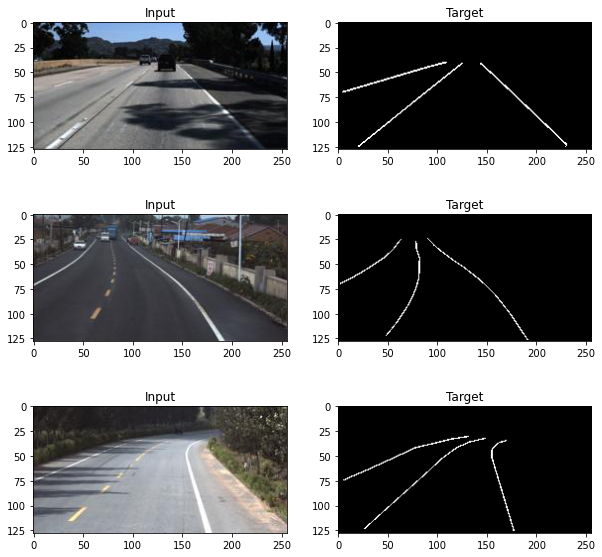

In [46]:
plt.figure(figsize=(10, 10))
for i, (data, target) in enumerate(basic_demo_loader_normal):
    if i >= 3:
        break
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(torch.permute(data.squeeze(), (1, 2, 0)))
    plt.title('Input')
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(target.squeeze(), cmap='gray')
    plt.title('Target')
    
# plt.savefig('./saved_images' + "/data" + ".png")
plt.show()

# Training

In [19]:
NUM_EPOCHS = 10
learning_rate = 0.001
class_weight = torch.tensor([0.02, 1.02])
criterion = torch.nn.CrossEntropyLoss(weight=class_weight).to(device)

### Training the CNN-only model

In [21]:
model_cnnonly = VGG11_SegNet_pretrained().to(device)
optimizer = torch.optim.Adam(model_cnnonly.parameters(), learning_rate)

early_stopping = EarlyStopping(
        patience=2,
        save_path=pretrained_models_path +
        model_cnnonly.__class__.__name__,
        min_delta=0.001)

In [22]:
train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_losses.append(
        train(
            model_cnnonly,
            epoch,
            train_loader_normal,
            optimizer,
            criterion,
            10,
            device))
    val_loss = val(model_cnnonly, epoch, val_loader_normal, criterion, device)
    val_losses.append(val_loss)
    if early_stopping(model_cnnonly, val_loss):
        break

KeyboardInterrupt: 

### Training the ConvLSTM model

In [23]:
model_convlstm = VGG11_SegNet_ConvLSTM_pretrained().to(device)
optimizer = torch.optim.Adam(model_convlstm.parameters(), learning_rate)

early_stopping = EarlyStopping(
        patience=2,
        save_path=pretrained_models_path +
        model_convlstm.__class__.__name__,
        min_delta=0.001)

In [24]:
train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_losses.append(
        train(
            model_convlstm,
            epoch,
            train_loader_sequence,
            optimizer,
            criterion,
            10,
            device))
    val_loss = val(model_convlstm, epoch, val_loader_sequence, criterion, device)
    val_losses.append(val_loss)
    if early_stopping(model_convlstm, val_loss):
        break

KeyboardInterrupt: 

# Testing

## CNN-only model

### Loading pretrained model

In [25]:
model_cnnonly = VGG11_SegNet_pretrained().to(device)
pretrained_dict = torch.load(pretrained_models_path + "VGG11_SegNet_pretrained17000", map_location=device)
model_dict = model_cnnonly.state_dict()
pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
model_dict.update(pretrained_dict_1)
model_cnnonly.load_state_dict(model_dict)

<All keys matched successfully>

### Example of a prediction

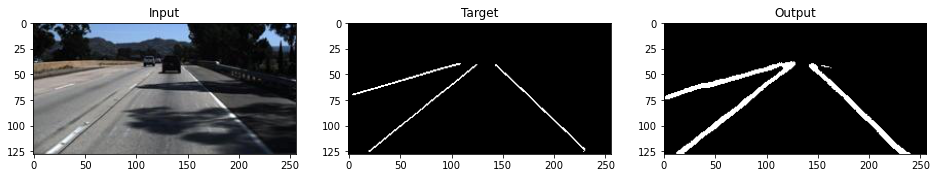

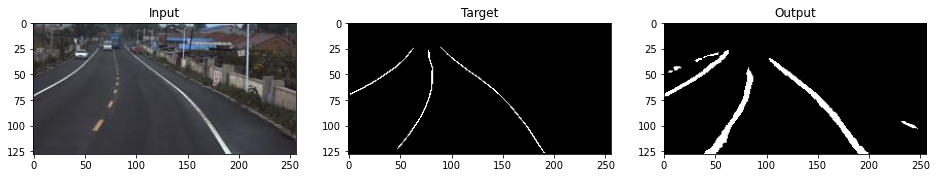

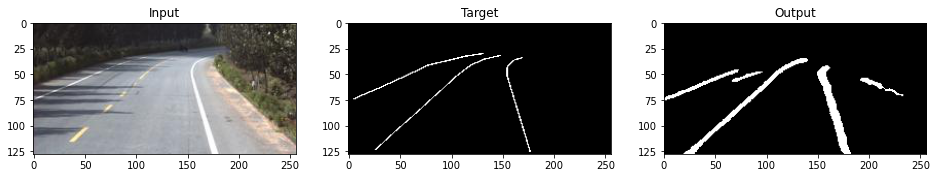

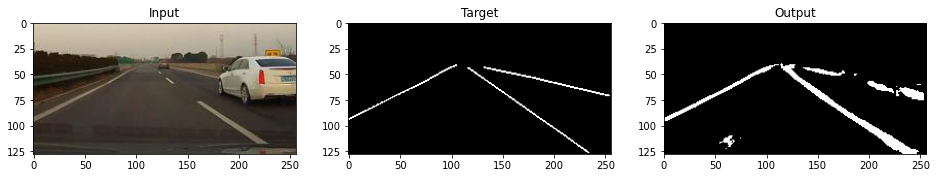

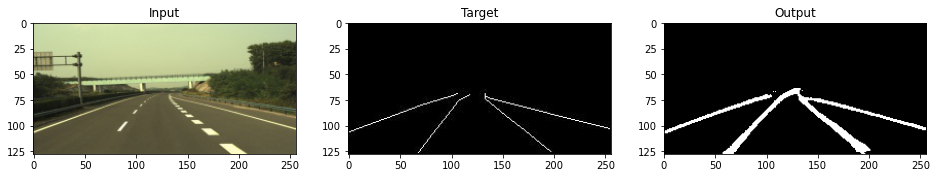

In [26]:
get_prediction(model_cnnonly, basic_demo_loader_normal, device, saved_images_path)

### Obtaining evaluation scores

In [27]:
test_loss, test_acc, precision, recall, f1 = get_evaluation_scores(
                                                     model_cnnonly,
                                                     test_loader_normal,
                                                     device,
                                                     criterion)

print('\nAverage loss: {:.4f}, Accuracy: {:.4f}%'.format(
      test_loss, test_acc))

print("Precision: {:.4f}\nRecall: {:.4f}\nF1-measure: {:.4f}"
      .format(precision, recall, f1))


Average loss: 1.0444, Accuracy: 94.7378%
Precision: 0.2732
Recall: 0.8351
F1-measure: 0.4117


## ConvLSTM model

### Loading pretrained model

In [28]:
model_convlstm = VGG11_SegNet_ConvLSTM_pretrained().to(device)
pretrained_dict = torch.load(pretrained_models_path + "VGG11_SegNet_ConvLSTM_pretrained17000", map_location=device)
model_dict = model_convlstm.state_dict()
pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
model_dict.update(pretrained_dict_1)
model_convlstm.load_state_dict(model_dict)

<All keys matched successfully>

### Example of a prediction

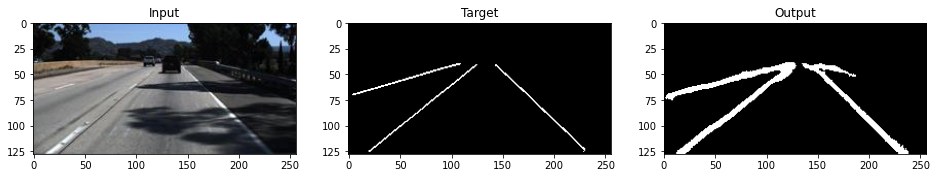

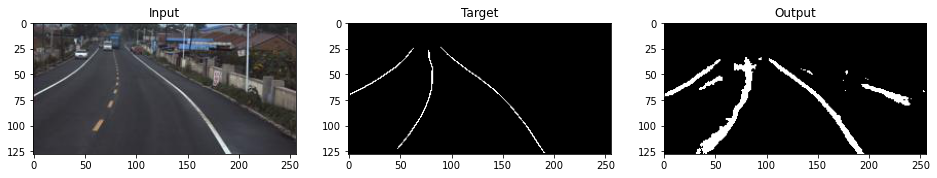

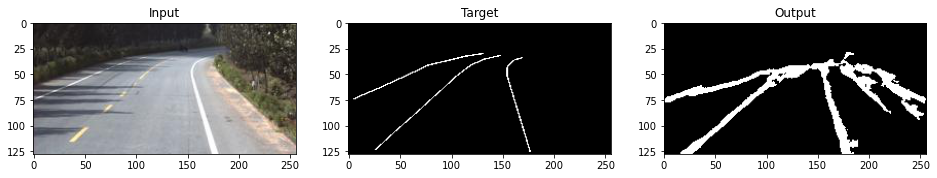

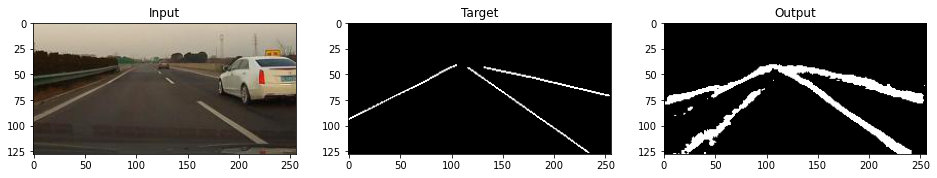

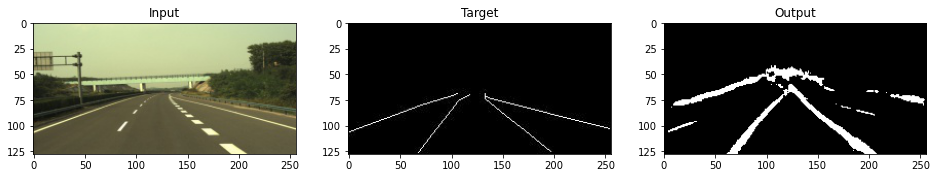

In [29]:
get_prediction(model_convlstm, basic_demo_loader_sequence, device, saved_images_path)

### Obtaining evaluation scores

In [31]:
test_loss, test_acc, precision, recall, f1 = get_evaluation_scores(
                                                     model_convlstm,
                                                     test_loader_sequence,
                                                     device,
                                                     criterion)

print('\nAverage loss: {:.4f}, Accuracy: {:.4f}%'.format(
      test_loss, test_acc))

print("Precision: {:.4f}\nRecall: {:.4f}\nF1-measure: {:.4f}"
      .format(precision, recall, f1))


Average loss: 1.4949, Accuracy: 93.4196%
Precision: 0.2181
Recall: 0.7679
F1-measure: 0.3398


## Side-by-side comparision of challenging example

In [49]:
def create_collage(model1, test_loader1, model2, test_loader2, save_dir='./saved_images', device=torch.device('cpu')):
    num_inputs = len(test_loader1)
    model1.eval()
    model2.eval()
    with torch.no_grad():
        for i, ((data1, target1), (data2, target2)) in enumerate(zip(test_loader1, test_loader2)):
            data1 = data1.to(device)
            target1 = target1.to(device)
            output1 = model1(data1)
            pred1 = torch.max(output1, dim=1)[1].squeeze()
            lane_img1 = np.uint8(pred1.numpy() * 255)
            
            data2 = data2.to(device)
            target2 = target2.to(device)
            output2 = model2(data2)
            pred2 = torch.max(output2, dim=1)[1].squeeze()
            lane_img2 = np.uint8(pred2.numpy() * 255)
            
            plt.figure(figsize=(16, 16))
            plt.subplot(num_inputs, 4, 4 * i + 1)
            plt.imshow(torch.permute(data1.squeeze(), (1, 2, 0)))
            plt.title('Input')
            plt.subplot(num_inputs, 4, 4 * i + 2)
            plt.imshow(target1.squeeze(), cmap='gray')
            plt.title('Target')
            plt.subplot(num_inputs, 4 ,4 * i + 3)
            plt.title('CNN-only')
            plt.imshow(lane_img1, cmap='gray')
            plt.subplot(num_inputs, 4 ,4 * i + 4)
            plt.title('With ConvLSTM')
            plt.imshow(lane_img2, cmap='gray')
            if save_dir is not None:
                plt.savefig(save_dir + "/collage" + str(i) + ".png")
            plt.show()

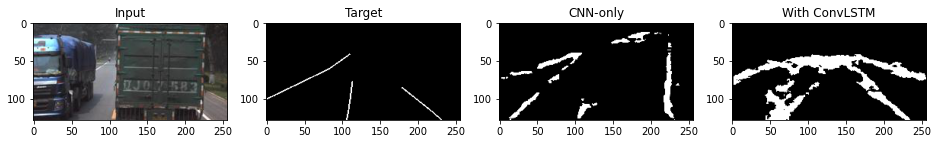

In [52]:
create_collage(model_cnnonly, test_challenging_loader_normal, model_convlstm, test_challenging_loader_sequence)

## Plotting performance against number of training samples

In [82]:
model1_name = "VGG11_SegNet_pretrained"
model2_name = "VGG11_SegNet_ConvLSTM_pretrained"

In [83]:
test_loss_model1 = []
test_acc_model1 = []
precision_model1 = []
recall_model1 = []
F1_measure_model1 = []

test_loss_model2 = []
test_acc_model2 = []
precision_model2 = []
recall_model2 = []
F1_measure_model2 = []

In [85]:
for sample_size in range(1000, 18000, 1000):
    print("Training dataset length:", sample_size)
    print("<------Model 1------->")
    model1_path = pretrained_models_path + model1_name + str(sample_size)
    pretrained_dict = torch.load(model1_path)
    model_dict = model1.state_dict()
    pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
    model_dict.update(pretrained_dict_1)
    model1.load_state_dict(model_dict)
    loss, acc, precision, recall, f1 = evaluate_model(model1, evaluate_test_loader_normal, device, criterion)
    test_loss_model1.append(loss)
    test_acc_model1.append(acc)
    precision_model1.append(precision)
    recall_model1.append(recall)
    F1_measure_model1.append(f1)

    print("<------Model 2------->")
    model2_path = pretrained_models_path + model2_name + str(sample_size)
    pretrained_dict = torch.load(model2_path)
    model_dict = model2.state_dict()
    pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
    model_dict.update(pretrained_dict_1)
    model2.load_state_dict(model_dict)
    loss, acc, precision, recall, f1 = evaluate_model(model2, evaluate_test_loader_sequence, device, criterion)
    test_loss_model2.append(loss)
    test_acc_model2.append(acc)
    precision_model2.append(precision)
    recall_model2.append(recall)
    F1_measure_model2.append(f1)

Training dataset length: 1000
<------Model 1------->


FileNotFoundError: [Errno 2] No such file or directory: './pretrained/VGG11_SegNet_pretrained1000'

In [86]:
X = np.arange(1000, 18000, 1000)

In [ ]:
plt.figure()
plt.plot(X, test_loss_model1, label='CNN-only')
plt.plot(X, test_loss_model2, label='With ConvLSTM')
plt.xlabel('No. samples in training set')
plt.ylabel('Test loss')
plt.legend()
# plt.savefig('./Test loss.png')
plt.show()

In [ ]:
plt.figure()
plt.plot(X, test_acc_model1, label='CNN-only')
plt.plot(X, test_acc_model2, label='With ConvLSTM')
plt.xlabel('No. samples in training set')
plt.ylabel('Test accuracy (%)')
plt.legend()
# plt.savefig('./Test accuracy.png')
plt.show()

In [ ]:
plt.figure()
plt.plot(X, precision_model1, label='CNN-only')
plt.plot(X, precision_model2, label='With ConvLSTM')
plt.xlabel('No. samples in training set')
plt.ylabel('Precision')
# plt.savefig('./precision.png')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(X, recall_model1, label='CNN-only')
plt.plot(X, recall_model2, label='With ConvLSTM')
plt.xlabel('No. samples in training set')
plt.ylabel('Recall')
# plt.savefig('./recall.png')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(X, F1_measure_model1, label='CNN-only')
plt.plot(X, F1_measure_model2, label='With ConvLSTM')
plt.xlabel('No. samples in training set')
plt.ylabel('F1-measure')
# plt.savefig('./F1-measure.png')
plt.legend()
plt.show()